In [1]:
import pandas as pd

df = pd.read_csv("../data/merge/openstack.csv")

Bài toán phát hiện chuỗi log bất thường là việc **chuyển góc nhìn từ log dòng đơn lẻ sang hành vi hệ thống**, bằng cách **gom log theo ngữ cảnh (context)** để tạo thành **chuỗi sự kiện theo thời gian**.
Một chuỗi được xem là bất thường khi **hành vi của nó phá vỡ những mẫu hành vi ổn định đã quan sát được trong hệ thống**, dù từng dòng log riêng lẻ có thể hoàn toàn bình thường.

In [2]:
df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df = df.sort_values("timestamp")
#Convet ParameterList from string to list
df["ParameterList"] = df["ParameterList"].apply(lambda x: x.strip("[]").split(", ") if pd.notnull(x) else [])

sequences = (
    df.groupby("Context")
        .agg({
            "EventId": list,
            "timestamp": list,
            "Component": list,
            "Level": list,
            "ParameterList": list
        })
        .reset_index()
)

print("Number of sequences:", len(sequences))

Number of sequences: 90407


In [3]:
sequences["EventCount"] = sequences["EventId"].apply(len)
threshold = sequences["EventCount"].quantile(0.99)

sequences_clean = sequences[sequences["EventCount"] <= threshold]
outliers = sequences[sequences["EventCount"] > threshold]

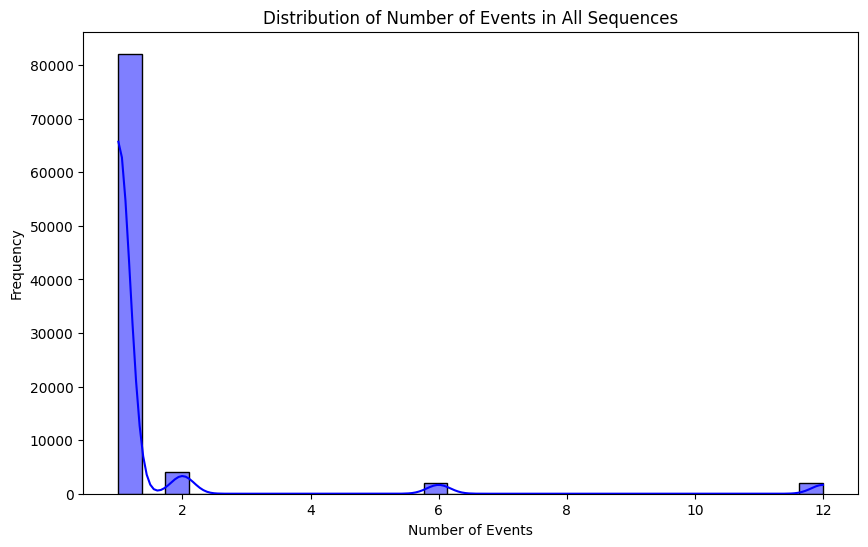

In [5]:
from matplotlib import pyplot as plt
import seaborn as sns

# Distribution of event counts in sequences
plt.figure(figsize=(10, 6))
sns.histplot(sequences_clean['EventCount'], bins=30, kde=True, color='blue')
plt.title("Distribution of Number of Events in All Sequences")
plt.xlabel("Number of Events")
plt.ylabel("Frequency")
plt.show()

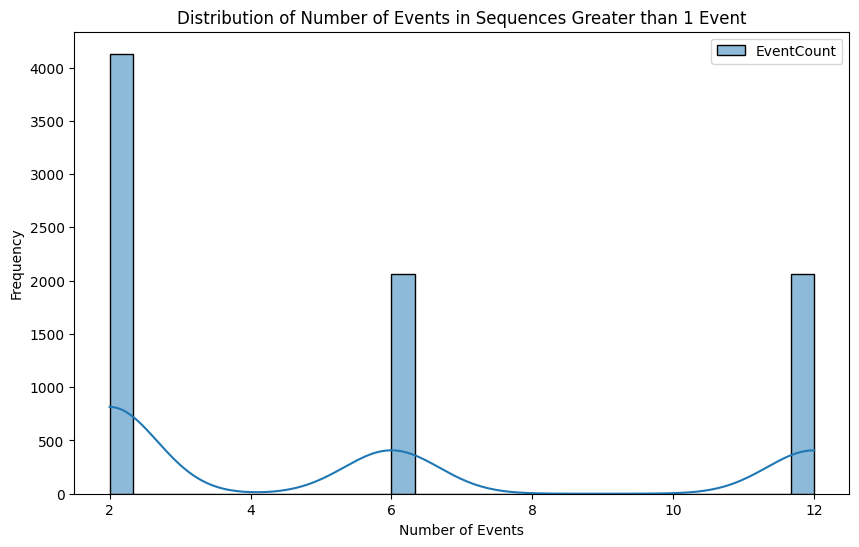

In [7]:
plt.figure(figsize=(10, 6))
sns.histplot(sequences_clean[sequences_clean['EventCount'] > 1], bins=30, kde=True, color='blue')
plt.title("Distribution of Number of Events in Sequences Greater than 1 Event")
plt.xlabel("Number of Events")
plt.ylabel("Frequency")
plt.show()

In [4]:
outliers

,Context,EventId,timestamp,Component,Level,ParameterList,EventCount
0,-,"[c583951f, 899b89e9, fe9c1237, c1d6825f, c1d68...","[2017-05-14 19:39:03.166000, 2017-05-14 19:39:...","[nova.compute.manager, nova.virt.libvirt.drive...","[INFO, INFO, INFO, INFO, INFO, INFO, INFO, INF...","[['2b590f10-49fd-4ec9-ae41-19596c2f4b25', 'Sto...",15462
22221,req-3ea4052c-895d-4b64-9e2d-04d64c4d94ab - - -...,"[c583951f, c583951f, fe9c1237, c583951f, fe9c1...","[2017-05-14 19:39:14.913000, 2017-05-14 19:39:...","[nova.compute.manager, nova.compute.manager, n...","[INFO, INFO, INFO, INFO, INFO, INFO, INFO, INF...","[['3edec1e4-9678-4a3a-a21b-a145a4ee5e61', 'Sta...",12248
61274,req-addc1839-2ed5-4778-b57e-5854eb7b8b09 - - -...,"[7d8b6b51, 904416f0, 1ea73ca5, b36febb0, 90441...","[2017-05-14 19:39:09.660000, 2017-05-14 19:39:...","[nova.compute.manager, nova.virt.libvirt.image...","[WARNING, INFO, INFO, INFO, INFO, INFO, INFO, ...","[['1', '0'], ['0673dd71-34c5-4fbb-86c4-40623fb...",52349


In [5]:
# Save sequences
one_event_sequences = sequences_clean[sequences_clean["EventCount"] == 1]
other_sequences = sequences_clean[sequences_clean["EventCount"] > 1]

one_event_sequences.to_csv("../data/processed/one_event_sequences.csv", index=False)
other_sequences.to_csv("../data/processed/other_sequences.csv", index=False)

eventId2EventTemplate = dict(zip(df["EventId"], df["EventTemplate"]))
# Save eventId to eventTemplate as json
import json
with open("../data/processed/eventId2EventTemplate.json", "w") as f:
    json.dump(eventId2EventTemplate, f)

In [6]:
print("Number of one-event sequences:", len(one_event_sequences))
print("Number of other sequences:", len(other_sequences))

Number of one-event sequences: 82142
Number of other sequences: 8262


In [10]:
# Statistics of Event Counts
print("Statistics of Event Counts in Sequences Greater than 1 Event:")
print(other_sequences["EventCount"].describe())

Statistics of Event Counts in Sequences Greater than 1 Event:
count    8262.000000
mean        5.499274
std         4.092199
min         2.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        12.000000
Name: EventCount, dtype: float64
